## Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import YouTube Metadata

In [2]:
import pickle
import os
## youtube module load from drive folder

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import TensorDataset, DataLoader

##### IMPORT ALL THUMBNAIL IMAGES FROM YOUTUBE DATASET AND CONVERT TO GRAYSCALE ####

os.chdir('/content/drive/MyDrive/')
## youtube module load from drive folder
import youtube.ytf

assert os.path.isfile('yt_metadata_complete.pkl') # assert file exists and load the file
with open('yt_metadata_complete.pkl', 'rb') as handle:
  yt_metadata_complete = pickle.load(handle)

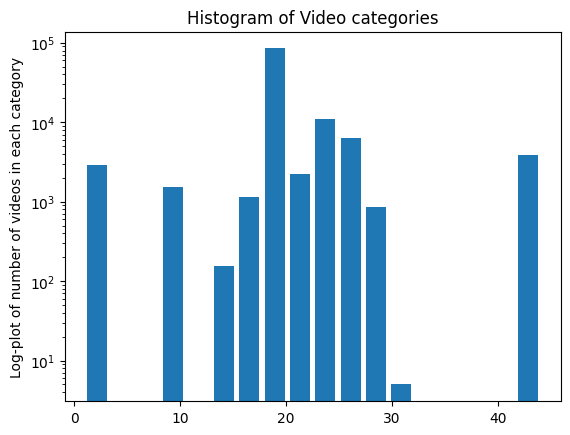

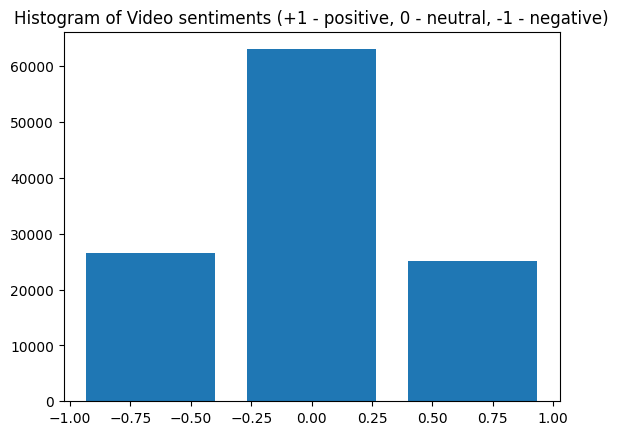

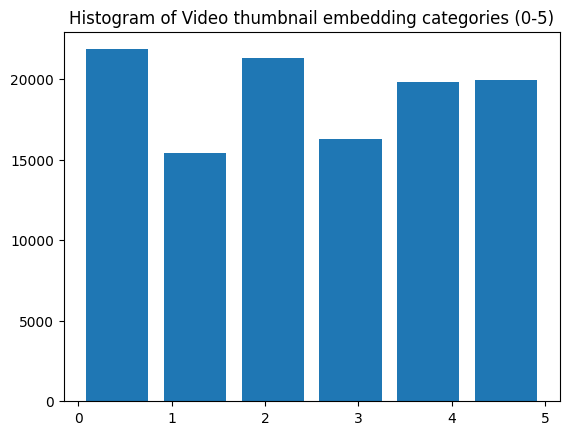

Video counts by category: 
Videos in category number 20 = 84758
Videos in category number 24 = 10188
Videos in category number 43 = 3849
Videos in category number 25 = 3588
Videos in category number 1 = 2749
Videos in category number 26 = 2252
Videos in category number 22 = 2247
Videos in category number 10 = 1542
Videos in category number 17 = 1145
Videos in category number 23 = 653
Videos in category number 27 = 481
Videos in category number 29 = 467
Videos in category number 28 = 391
Videos in category number 2 = 169
Videos in category number 15 = 156
Videos in category number 19 = 72
Videos in category number 44 = 12
Videos in category number 30 = 5


In [3]:
vid_categs = [metadata_dict['vidFeatures'][1] for metadata_dict in yt_metadata_complete]
vid_sentiments = [metadata_dict['vidSentiment'] for metadata_dict in yt_metadata_complete]
vid_embed_categs = [metadata_dict['cluster_category'] for metadata_dict in yt_metadata_complete]

unique_categs  = list(set(vid_categs))
unique_sentiments  = list(set(vid_sentiments))
unique_embed_categs  = list(set(vid_embed_categs))

plt.hist(vid_categs,bins = len(set(vid_categs)), histtype='bar', rwidth=0.8)
plt.yscale('log')
plt.ylabel('Log-plot of number of videos in each category')
plt.title('Histogram of Video categories')
plt.show()

plt.hist(vid_sentiments,bins = len(set(vid_sentiments)), histtype='bar', rwidth=0.8)
plt.title('Histogram of Video sentiments (+1 - positive, 0 - neutral, -1 - negative)')
plt.show()

plt.hist(vid_embed_categs,bins = len(set(vid_embed_categs)), histtype='bar', rwidth=0.8)
plt.title('Histogram of Video thumbnail embedding categories (0-5)')
plt.show()



# video counts by category
vid_counts = [(categ,vid_categs.count(categ)) for categ in unique_categs]
vid_counts = sorted(vid_counts,key = lambda x: x[1], reverse=True) # sort by video counts of each category
print('Video counts by category: ')
for i in range(len(unique_categs)):
  print("Videos in category number {} = {}".format(vid_counts[i][0],vid_counts[i][1])) 

In [4]:
yt_metadata_complete[0]

{'vidLabels': [159, 0, 2, 0, 0, 0, 1, 1, 0],
 'vidFeatures': [801,
  20,
  10272567,
  14120,
  27301,
  3097,
  3097,
  12005,
  3854,
  8151],
 'vidSentiment': 1,
 'thumbnail_embedding': [0.9110659,
  0.5966198,
  0.7948525,
  0.03379264,
  0.5910631,
  0.1942662,
  0.7249774,
  0.9996307,
  0.40471157,
  0.0006674013,
  0.99947625,
  0.0016979049,
  0.024134263,
  0.4851897,
  0.8221577,
  0.24807963],
 'cluster_category': 2}

## Filter data - eliminate categories with videos fewer than 1500 videos (8/18 categories go through)

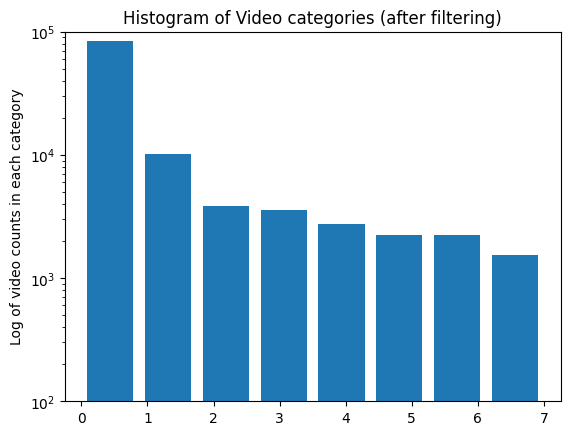

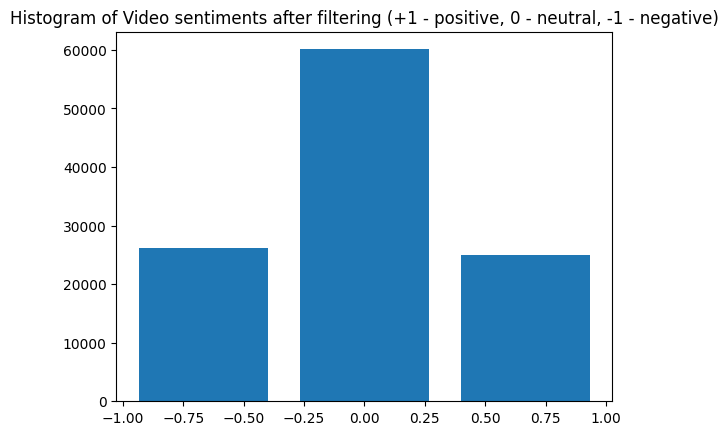

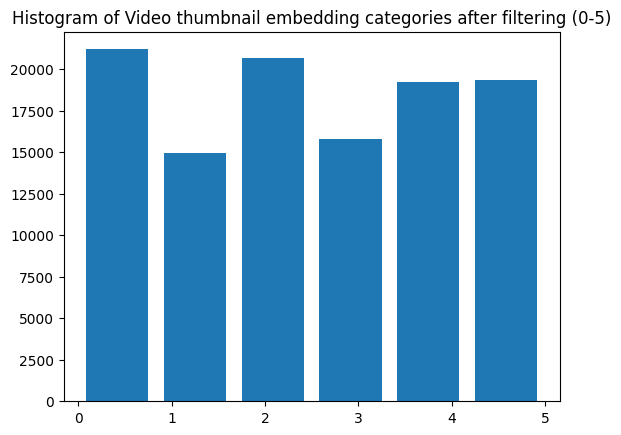

Video counts by category: 
Videos in category number 0 = 84758
Videos in category number 1 = 10188
Videos in category number 2 = 3849
Videos in category number 3 = 3588
Videos in category number 4 = 2749
Videos in category number 5 = 2252
Videos in category number 6 = 2247
Videos in category number 7 = 1542


In [5]:
vid_counts_filtered = vid_counts[:8]
unique_categs_filtered  = [elem[0] for elem in vid_counts_filtered]

yt_metadata_complete_filtered = []
for metadata_dict in yt_metadata_complete:
  if metadata_dict['vidFeatures'][1] in unique_categs_filtered:
    metadata_dict['vid_category_index'] = unique_categs_filtered.index(metadata_dict['vidFeatures'][1]) # add category index (0-7)
    metadata_dict['number_views'] = min(2*10**6,metadata_dict['vidLabels'][0]) # viewcount clipped
    metadata_dict['comment_engagement'] = min(1,metadata_dict['vidLabels'][1]/metadata_dict['number_views']) if metadata_dict['number_views']!=0 else 0  # ratio of comments to viewcounts
    metadata_dict['likes_dislikes_engagement'] = min(1,(metadata_dict['vidLabels'][2] +  metadata_dict['vidLabels'][3])/metadata_dict['number_views']) if metadata_dict['number_views']!=0 else 0 # normalized sum of likes and dislikes
    metadata_dict['polarization'] = (metadata_dict['vidLabels'][2] -  metadata_dict['vidLabels'][3])/(metadata_dict['vidLabels'][2] +  metadata_dict['vidLabels'][3]) if (metadata_dict['vidLabels'][2] +  metadata_dict['vidLabels'][3]) != 0 else 0  # normalized difference in likes and dislikes (+ve = positive, -ve = neutral)
    yt_metadata_complete_filtered.append(metadata_dict)

with open('yt_metadata_complete_filtered.pkl', 'wb') as handle:
  pickle.dump(yt_metadata_complete_filtered,handle,protocol = pickle.HIGHEST_PROTOCOL)



vid_categ_indices_filtered = [metadata_dict['vid_category_index'] for metadata_dict in yt_metadata_complete_filtered]
vid_sentiments_filtered = [metadata_dict['vidSentiment'] for metadata_dict in yt_metadata_complete_filtered]
vid_embed_categs_filtered = [metadata_dict['cluster_category'] for metadata_dict in yt_metadata_complete_filtered]

unique_sentiments_filtered  = list(set(vid_sentiments_filtered))
unique_embed_categs_filtered  = list(set(vid_embed_categs_filtered))


plt.hist(vid_categ_indices_filtered, bins = len(set(unique_categs_filtered)), histtype='bar', rwidth=0.8)
plt.yscale('log')
plt.ylabel('Log of video counts in each category')
plt.ylim((10**2,10**5))
plt.title('Histogram of Video categories (after filtering)')
plt.show()

plt.hist(vid_sentiments_filtered,bins = len(set(vid_sentiments_filtered)), histtype='bar', rwidth=0.8)
plt.title('Histogram of Video sentiments after filtering (+1 - positive, 0 - neutral, -1 - negative)')
plt.show()

plt.hist(vid_embed_categs_filtered,bins = len(set(vid_embed_categs_filtered)), histtype='bar', rwidth=0.8)
plt.title('Histogram of Video thumbnail embedding categories after filtering (0-5)')
plt.show()



# video counts by category
vid_counts_filtered = [(categ,vid_categ_indices_filtered.count(categ)) for categ in list(range(8))]
vid_counts_filtered = sorted(vid_counts_filtered,key = lambda x: x[1], reverse=True) # sort by video counts of each category
print('Video counts by category: ')
for i in range(len(unique_categs_filtered)):
  print("Videos in category number {} = {}".format(vid_counts_filtered[i][0],vid_counts_filtered[i][1]))

In [6]:
yt_metadata_complete[19000]

{'vidLabels': [563, 1, 4, 0, 0, 0, 0, 0, 0],
 'vidFeatures': [82, 20, 154415, 693, 522, 41, 41, 66, 7, 59],
 'vidSentiment': -1,
 'thumbnail_embedding': [0.0024978588,
  0.67057157,
  0.008462194,
  0.56368685,
  0.5645818,
  0.48447856,
  0.005841303,
  0.34485105,
  0.45933083,
  0.653052,
  0.29369342,
  0.64045787,
  0.5143578,
  0.6349402,
  0.0032970433,
  0.50850827],
 'cluster_category': 3,
 'vid_category_index': 0,
 'number_views': 563,
 'comment_engagement': 0.0017761989342806395,
 'likes_dislikes_engagement': 0.007104795737122558,
 'polarization': 1.0}

## Divide data into video categories: Dictionary with key = video category, value = {state: state_value, action: action_value}
## state_value = {embedding_category, title_sentiment}
## action_value = {viewcount, comment_engagement, likes_dislikes_engagement, polarization}
## number of states - sentiment (-1,0,+1) x embed_category (0-5) -> 18 states
## number of actions - viewcount (high,low) x comment engagement (high,low) x likes dislikes engagement (high,low) x polarization (positive, negative, neural) - 24 actions

In [7]:
yt_metadata_by_category = {}
for metadata in yt_metadata_complete_filtered:
  action_data = {
      'number_views':metadata['number_views'],
      'comment_engagement':metadata['comment_engagement'],
      'likes_dislikes_engagement':metadata['likes_dislikes_engagement'],
      'polarization':metadata['polarization']
  }
  state_data = {
      'embedding_category': metadata['cluster_category'],
      'title_sentiment':metadata['vidSentiment']
  }
  if metadata['vid_category_index'] not in yt_metadata_by_category.keys():
    yt_metadata_by_category[metadata['vid_category_index']] = [{'state':state_data, 'action':action_data}]
  else:
    yt_metadata_by_category[metadata['vid_category_index']].append({'state':state_data, 'action':action_data})

with open('yt_metadata_complete_filtered_by_category.pkl', 'wb') as handle:
  pickle.dump(yt_metadata_by_category,handle,protocol = pickle.HIGHEST_PROTOCOL)

## Thresholding for categorizing action space

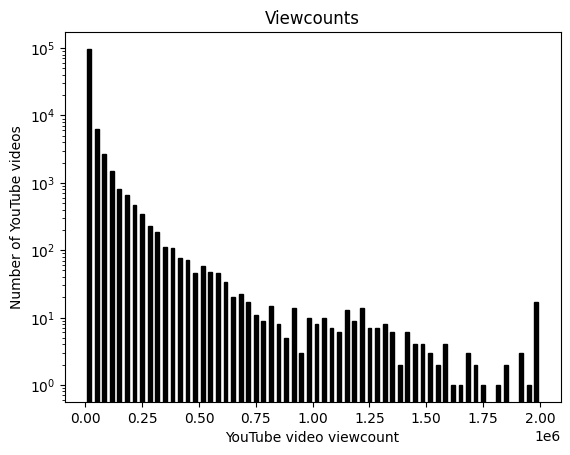

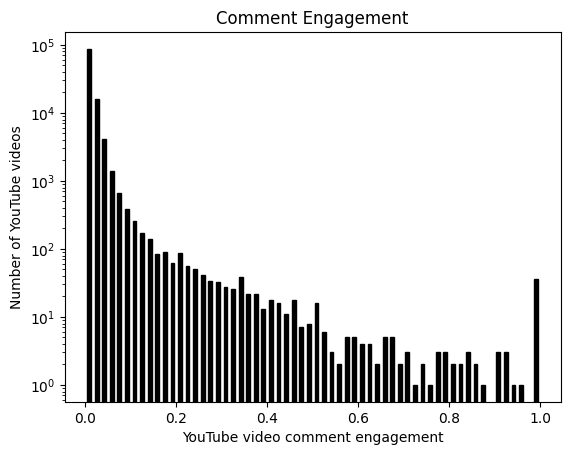

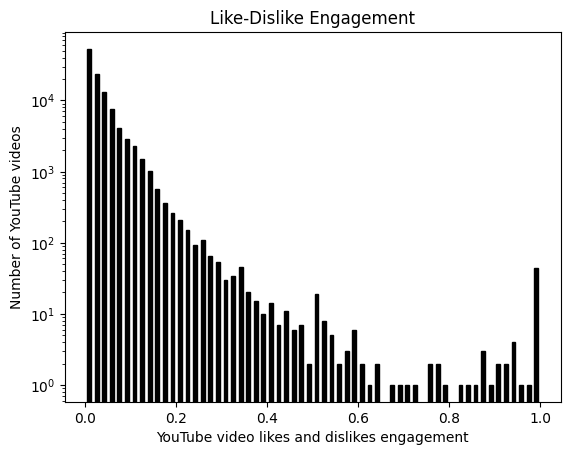

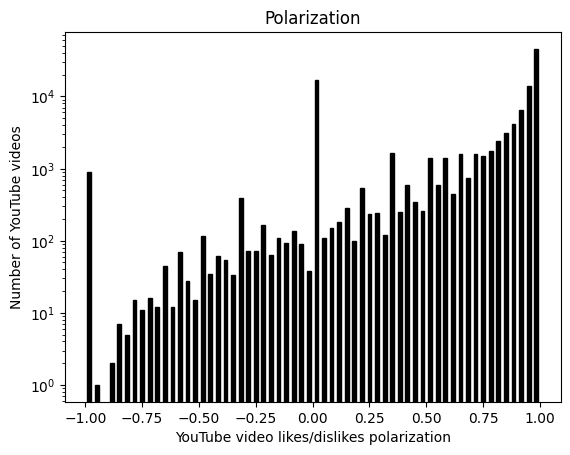

In [8]:
viewcounts = [metadata['number_views'] for metadata in yt_metadata_complete_filtered]
commentengagement = [metadata['comment_engagement'] for metadata in yt_metadata_complete_filtered]
likedislike_engagement = [metadata['likes_dislikes_engagement'] for metadata in yt_metadata_complete_filtered]
polarization = [metadata['polarization'] for metadata in yt_metadata_complete_filtered]


plt.hist(viewcounts, bins = 60, range = (0,2*10**6), histtype='bar', rwidth=0.5, color = "black", ec="black")
plt.yscale('log')
plt.xlabel('YouTube video viewcount')
plt.ylabel('Number of YouTube videos')
plt.title('Viewcounts')
plt.show()

plt.hist(commentengagement,bins = 60, range = (0,1), histtype='bar', rwidth=0.5, color = "black", ec="black")
plt.yscale('log')
plt.xlabel('YouTube video comment engagement')
plt.ylabel('Number of YouTube videos')
plt.title('Comment Engagement')
plt.show()

plt.hist(likedislike_engagement, bins = 60, range = (0,1), histtype='bar', rwidth=0.5, color = "black", ec="black")
plt.yscale('log')
plt.xlabel('YouTube video likes and dislikes engagement')
plt.ylabel('Number of YouTube videos')
plt.title('Like-Dislike Engagement')
plt.show()

plt.hist(polarization, bins = 60, range = (-1,1), histtype='bar', rwidth=0.5, color = "black", ec="black")
plt.xlabel('YouTube video likes/dislikes polarization')
plt.ylabel('Number of YouTube videos')
plt.yscale('log')
plt.title('Polarization')
plt.show()

In [10]:
# Compute 50th percentiles for all action components and set them as thresholds
# Different thresholds based on viewcount (since a video's viewing dictates the remaining engagement parameters)
viewcount_thresh = np.median(viewcounts)
commentengagement_thresh_low = np.median([commentengagement[i] for i in range(len(commentengagement)) if viewcounts[i]<=viewcount_thresh])
commentengagement_thresh_high = np.median([commentengagement[i] for i in range(len(commentengagement)) if viewcounts[i]>viewcount_thresh])

likedislike_engagement_thresh_low = np.median([likedislike_engagement[i] for i in range(len(likedislike_engagement)) if viewcounts[i]<=viewcount_thresh])
likedislike_engagement_thresh_high = np.median([likedislike_engagement[i] for i in range(len(likedislike_engagement)) if viewcounts[i]>viewcount_thresh])


polarization_thresh_neg_low = np.median([polarization[i] for i in range(len(polarization)) if (viewcounts[i]<=viewcount_thresh and polarization[i]<0)] )
polarization_thresh_neg_high = np.median([polarization[i] for i in range(len(polarization)) if (viewcounts[i]>viewcount_thresh and polarization[i]<0)] )
polarization_thresh_pos_low = np.median([polarization[i] for i in range(len(polarization)) if (viewcounts[i]<=viewcount_thresh and polarization[i]>=0)] )
polarization_thresh_pos_high = np.median([polarization[i] for i in range(len(polarization)) if (viewcounts[i]>viewcount_thresh and polarization[i]>=0)] )

print('Viewcount Threshold: {}'.format(viewcount_thresh))
print('Comment Engagement Threshold: {:0.4f},{:0.4f}'.format(commentengagement_thresh_low,commentengagement_thresh_high))

print('Like/Dislike Engagement Threshold: {:0.4f},{:0.4f}'.format(likedislike_engagement_thresh_low,likedislike_engagement_thresh_high))

print('Positive Polarization Threshold: {:0.4f},{:0.4f}'.format(polarization_thresh_neg_low, polarization_thresh_neg_high))
print('Negative Polarization Threshold: {:0.4f},{:0.4f}'.format(polarization_thresh_pos_low, polarization_thresh_pos_high))


# Include thresholds in yt_metadata_by_category
yt_metadata_by_category['Thresholds'] = {
    'number_views':viewcount_thresh,
    'comment_engagement': (commentengagement_thresh_low,commentengagement_thresh_high),
    'likes_dislikes_engagement':(likedislike_engagement_thresh_low,likedislike_engagement_thresh_high),
    'polarization_negative':(polarization_thresh_neg_low,polarization_thresh_neg_high),
    'polarization_positive':(polarization_thresh_pos_low,polarization_thresh_pos_high)
}

# Discretize actions in yt_metadata_by_category[?]
for elem in list(list(yt_metadata_by_category.keys())):
  if type(elem) == int:
    for index in range(len(yt_metadata_by_category[elem])):
      yt_metadata_by_category[elem][index]['action_quantized'] = {}
      yt_metadata_by_category[elem][index]['action_quantized']['number_views'] = 1 if yt_metadata_by_category[elem][index]['action']['number_views'] >= viewcount_thresh else 0
      if yt_metadata_by_category[elem][index]['action_quantized']['number_views'] == 1:
        yt_metadata_by_category[elem][index]['action_quantized']['comment_engagement']= 1 if yt_metadata_by_category[elem][index]['action']['comment_engagement'] >= commentengagement_thresh_high else 0
        yt_metadata_by_category[elem][index]['action_quantized']['likes_dislikes_engagement'] = 1 if yt_metadata_by_category[elem][index]['action']['likes_dislikes_engagement'] >= likedislike_engagement_thresh_high else 0
        yt_metadata_by_category[elem][index]['action_quantized']['polarization'] = -1 if yt_metadata_by_category[elem][index]['action']['likes_dislikes_engagement']<= polarization_thresh_neg_high else (0 if yt_metadata_by_category[elem][index]['action']['likes_dislikes_engagement']<= polarization_thresh_pos_high else 1)
      else:
        yt_metadata_by_category[elem][index]['action_quantized']['comment_engagement']= 1 if yt_metadata_by_category[elem][index]['action']['comment_engagement'] >= commentengagement_thresh_low else 0
        yt_metadata_by_category[elem][index]['action_quantized']['likes_dislikes_engagement'] = 1 if yt_metadata_by_category[elem][index]['action']['likes_dislikes_engagement'] >= likedislike_engagement_thresh_low else 0
        yt_metadata_by_category[elem][index]['action_quantized']['polarization'] = -1 if yt_metadata_by_category[elem][index]['action']['likes_dislikes_engagement']<= polarization_thresh_neg_low else (0 if yt_metadata_by_category[elem][index]['action']['likes_dislikes_engagement']<= polarization_thresh_pos_low else 1)
        

with open('yt_metadata_complete_filtered_by_category_state_action_discretized.pkl', 'wb') as handle:
  pickle.dump(yt_metadata_by_category,handle,protocol = pickle.HIGHEST_PROTOCOL)

Viewcount Threshold: 1874.0
Comment Engagement Threshold: 0.0026,0.0087
Like/Dislike Engagement Threshold: 0.0098,0.0285
Positive Polarization Threshold: -0.5000,-0.2756
Negative Polarization Threshold: 0.9016,0.9528


In [ ]:
yt_metadata_by_category[0][1]['state']

{'embedding_category': 2, 'title_sentiment': -1}

## Compute state priors for every category

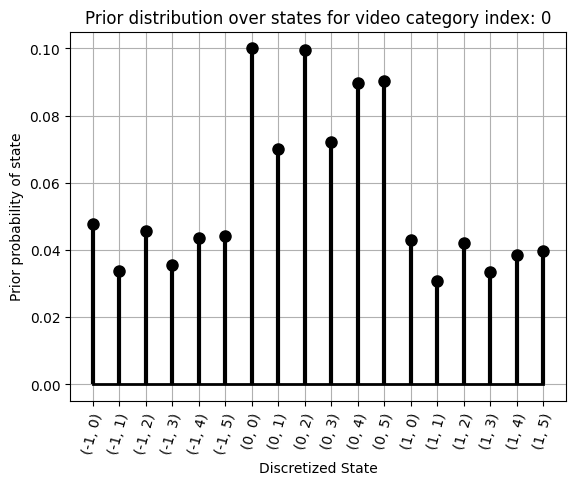

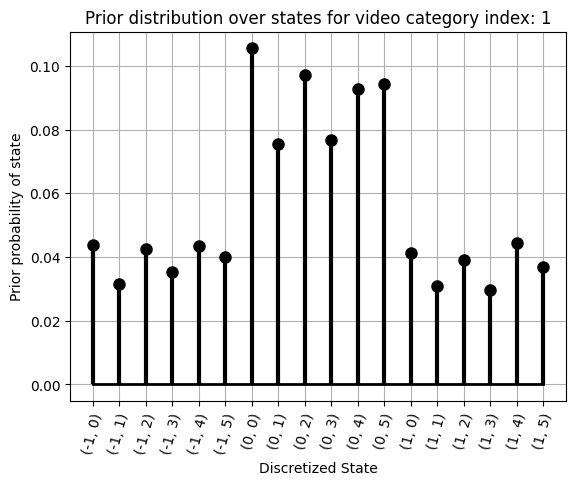

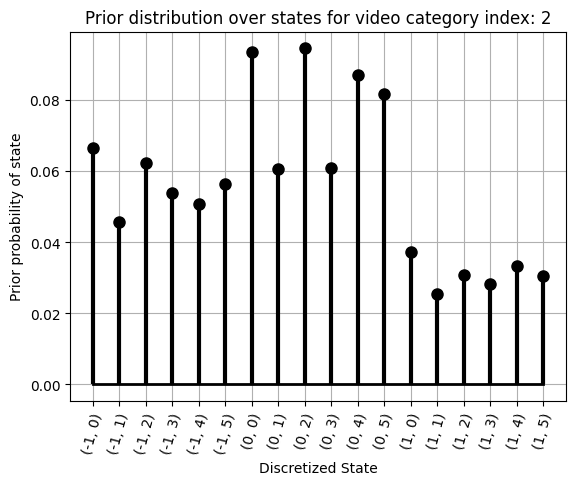

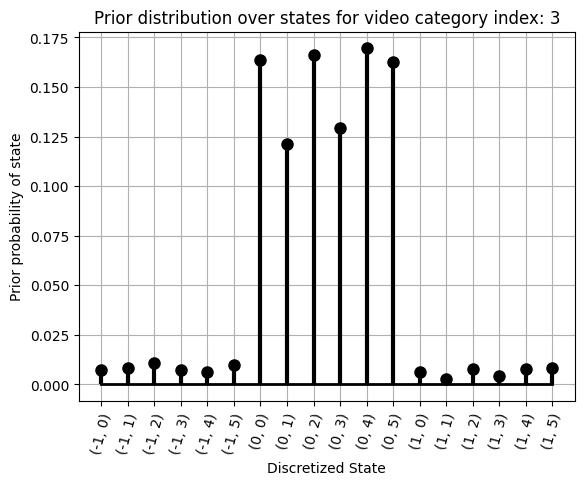

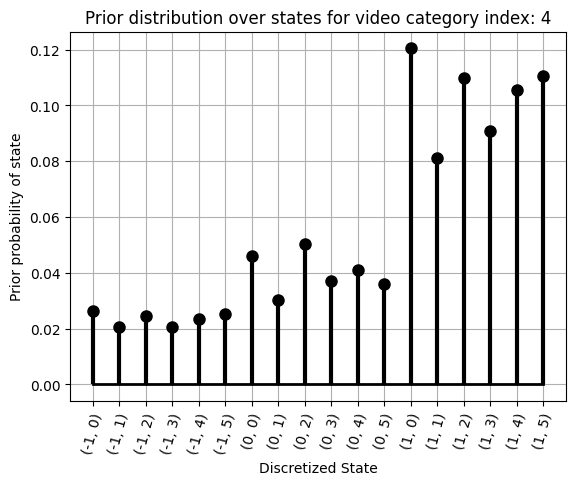

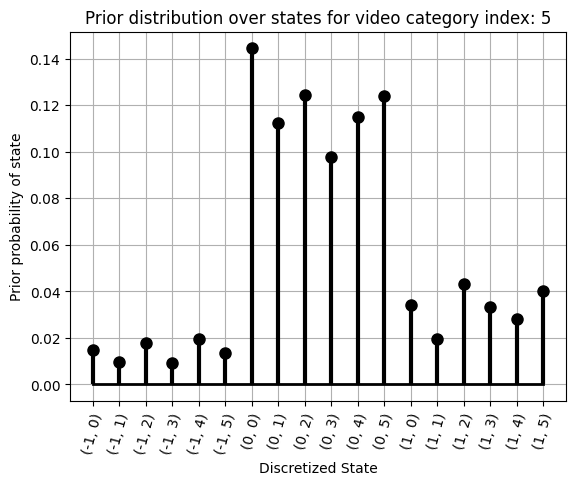

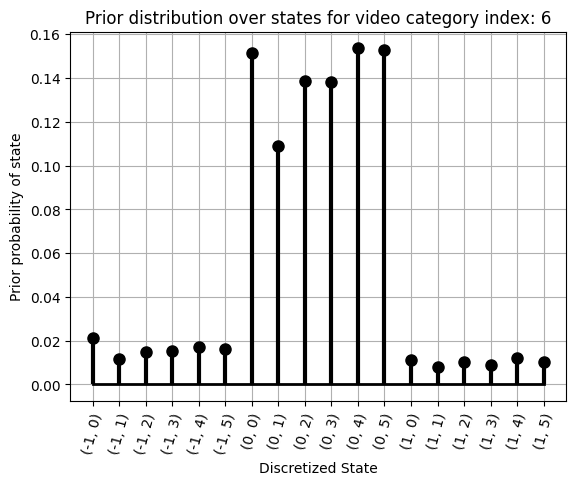

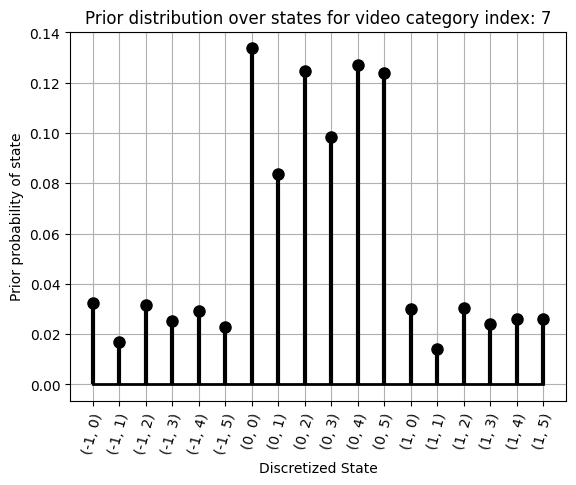

{'state_indexing': [(-1, 0), (-1, 1), (-1, 2), (-1, 3), (-1, 4), (-1, 5), (0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5)], 0: [0.04779489841666863, 0.03387290875197622, 0.04576559144859482, 0.035406687274357584, 0.04359470492460889, 0.04413742655560537, 0.09996696477028717, 0.0700582835838505, 0.09951862950989877, 0.07213478373722834, 0.08966705207767998, 0.0903513532645886, 0.04308737818259043, 0.03078175511456146, 0.04195474173529343, 0.03344817008423984, 0.038651218764010474, 0.03980745180395951], 1: [0.04387514723203769, 0.031507656065959955, 0.04259913623871221, 0.03513937966234786, 0.04348252846486062, 0.039850804868472714, 0.10541813898704358, 0.07538280329799764, 0.09717314487632508, 0.07656065959952886, 0.09265802905378877, 0.09432665881429132, 0.04122497055359246, 0.03082057322340008, 0.038967412642324305, 0.029740871613663133, 0.04426776599921476, 0.037004318806438945], 2: [0.06651078202130424, 0.04572616263964666, 0.0623538581

In [ ]:
import itertools
categ_priors = {}
categ_priors['state_indexing'] = list(itertools.product([-1,0,1],[0,1,2,3,4,5])) # return list of all tuples of [sentiment, cluster]
############################ ENSURE the values are correct (if either sentiment discretization or clustering params change)


vid_categories = sorted([elem for elem in list(list(yt_metadata_by_category.keys())) if type(elem)==int])
# store prior vectors for each category
for vid_category in vid_categories:
  prior = []
  states = [ (metadata['state']['title_sentiment'],metadata['state']['embedding_category']) for metadata in yt_metadata_by_category[vid_category]]
  for state in categ_priors['state_indexing']:
    prior.append(states.count(state)/len(states))
  categ_priors[vid_category] = prior

  #Display prior distribution
  markerline, stemlines, baseline = plt.stem(prior, linefmt='black', bottom=0)
  plt.setp(baseline, color='black', linewidth=2)
  plt.setp(stemlines, color='black', linewidth=3)
  plt.setp(markerline, color = 'black', markersize = 8)

  plt.xticks(list(range(len(categ_priors['state_indexing']))),categ_priors['state_indexing'], rotation = 75)
  plt.title('Prior distribution over states for video category index: {}'.format(vid_category))
  plt.xlabel('Discretized State')
  plt.ylabel('Prior probability of state')
  plt.grid('on')
  plt.show()

print(categ_priors) 

In [ ]:
yt_metadata_by_category[0][0]

{'state': {'embedding_category': 2, 'title_sentiment': 1},
 'action': {'number_views': 159,
  'comment_engagement': 0.0,
  'likes_dislikes_engagement': 0.012578616352201259,
  'polarization': 1.0},
 'action_quantized': {'number_views': 0,
  'comment_engagement': 0,
  'likes_dislikes_engagement': 1,
  'polarization': 0}}

## Compute action selection probabilities for every category

In [ ]:
action_counts = [0 for i in range(24)]
actions_list = list(itertools.product([0,1],[0,1],[0,1],[-1,0,1]))

valid_actions = []
for vid_category in vid_categories:
  actions = [ (metadata['action_quantized']['number_views'],metadata['action_quantized']['comment_engagement'],metadata['action_quantized']['likes_dislikes_engagement'],metadata['action_quantized']['polarization']) for metadata in yt_metadata_by_category[vid_category]]
  j=0
  for action in actions_list:
    action_counts[j] += actions.count(action)
    j=j+1

valid_actions_list = [actions_list[j] for j in range(len(actions_list)) if action_counts[j]>= 5000] # cutoff
# return list of all tuples of [viewcount, commenting engagement, like/dislike engagement, like/dislike polarity]
############################ ENSURE the values are correct (if action discretization strategy changes)

categ_action_selection_probs = {}
categ_action_selection_probs['state_indexing'] = list(itertools.product([-1,0,1],[0,1,2,3,4,5])) # return list of all tuples of [sentiment, cluster]
############################ ENSURE the values are correct (if either sentiment discretization or clustering params change)
# KEEP ONLY THOSE ACTIONS THAT APPEAR MORE THAN 5000 times IN THE YOUTUBE DATASET (13/24 possibilities are valid (>5000))


categ_action_selection_probs['action_indexing'] = valid_actions_list

vid_categories = sorted([elem for elem in list(list(yt_metadata_by_category.keys())) if type(elem)==int])
for vid_category in vid_categories:
  states = [ (metadata['state']['title_sentiment'],metadata['state']['embedding_category']) for metadata in yt_metadata_by_category[vid_category]]
  actions = [ (metadata['action_quantized']['number_views'],metadata['action_quantized']['comment_engagement'],metadata['action_quantized']['likes_dislikes_engagement'],metadata['action_quantized']['polarization']) for metadata in yt_metadata_by_category[vid_category]]
  actsel = []
  for state in categ_priors['state_indexing']:
    actsel_state = []
    for action in categ_action_selection_probs['action_indexing']:
      actions_state = [actions[i] for i in range(len(actions)) if states[i]==state] # all actions| state variable
      actsel_state.append(actions_state.count(action)) # p(a|x)
    actsel.append(list( np.array(actsel_state)/sum(actsel_state)) )

  categ_action_selection_probs[vid_category] = actsel

## Save categ_priors and categ_action_selection_probs

In [ ]:
with open('yt_metadata_category_priors.pkl', 'wb') as handle:
  pickle.dump(categ_priors,handle,protocol = pickle.HIGHEST_PROTOCOL)

with open('yt_metadata_category_action_selection_probs.pkl', 'wb') as handle:
  pickle.dump(categ_action_selection_probs,handle,protocol = pickle.HIGHEST_PROTOCOL)

## ALSO SAVE AS .mat files for MATLAB processing

In [ ]:
os.chdir('/content/drive/MyDrive/')
from scipy.io import savemat

priors_mat = {}
act_sel_mat = {}

for vid_category in vid_categories:
  priors_mat[str(vid_category)] = categ_priors[vid_category]
  act_sel_mat[str(vid_category)] = categ_action_selection_probs[vid_category]


savemat("yt_priors.mat",priors_mat)
savemat("yt_act_sel.mat",act_sel_mat)
##################################### PYTHON WORK DONE #########################
print(priors_mat,act_sel_mat)

{'0': [0.04779489841666863, 0.03387290875197622, 0.04576559144859482, 0.035406687274357584, 0.04359470492460889, 0.04413742655560537, 0.09996696477028717, 0.0700582835838505, 0.09951862950989877, 0.07213478373722834, 0.08966705207767998, 0.0903513532645886, 0.04308737818259043, 0.03078175511456146, 0.04195474173529343, 0.03344817008423984, 0.038651218764010474, 0.03980745180395951], '1': [0.04387514723203769, 0.031507656065959955, 0.04259913623871221, 0.03513937966234786, 0.04348252846486062, 0.039850804868472714, 0.10541813898704358, 0.07538280329799764, 0.09717314487632508, 0.07656065959952886, 0.09265802905378877, 0.09432665881429132, 0.04122497055359246, 0.03082057322340008, 0.038967412642324305, 0.029740871613663133, 0.04426776599921476, 0.037004318806438945], '2': [0.06651078202130424, 0.04572616263964666, 0.06235385814497272, 0.05378020265003897, 0.050922317485061055, 0.056378280072746166, 0.09353078721745908, 0.06053520394907768, 0.09457001818654195, 0.06105481943361912, 0.0870